The goal of this notebook is to perform a brief exploratory data analysis over 
the MIND News dataset, with a focus on the relationship between the article
title, it's category/subcategory, and it's performance in terms of clicks,
impressions, and click-through rate. 

This notebook will also provide results for dummy and simple, unoptimized models
for predicting CTR and subcategory from the article title. 

These will be used as a benchmark once deep learning models are tested.

# 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

# 1. Load Dataset

In [2]:
# Create an empty dictionary to store the column data
data = {}

# Open the HDF5 file using h5py
with h5py.File('../data/processed/news_clicks.hdf5', 'r') as f:
    # Iterate through the datasets in the HDF5 file
    for key in f.keys():
        # Load the dataset into a NumPy array
        data[key] = f[key][:]

# Create a Pandas DataFrame from the dictionary of column data
df = pd.DataFrame(data)

# Only interested in the below columns for this analysis
df = df[['category', 'clicks', 'ctr', 'impressions', 'news_id', 'subcategory',
         'title']]

# 2. Data Overview

In [3]:
df.head()

,category,clicks,ctr,impressions,news_id,subcategory,title
0,b'lifestyle',0,0.0,1,b'N88753',b'lifestyleroyals',"b'The Brands Queen Elizabeth, Prince Charles, ..."
1,b'news',0,0.0,0,b'N45436',b'newsscienceandtechnology',b'Walmart Slashes Prices on Last-Generation iP...
2,b'health',0,0.0,0,b'N23144',b'weightloss',b'50 Worst Habits For Belly Fat'
3,b'health',0,0.0,0,b'N86255',b'medical',"b""Dispose of unwanted prescription drugs durin..."
4,b'news',0,0.0,0,b'N93187',b'newsworld',"b""The Cost of Trump's Aid Freeze in the Trench..."


Convert bytestrings

In [4]:
for col in ('category', 'news_id', 'subcategory', 'title'):
    df[col] = df[col].str.decode('utf-8')

Basic stats over numeric columns

In [5]:
df.describe()

,clicks,ctr,impressions
count,101527.000000,101527.000000,101527.000000
mean,33.327647,0.010986,822.513952
std,547.961457,0.043067,7601.792894
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000
max,60638.000000,1.000000,331546.000000


Data is heavily right-skewed. 

Note: Should try log transform before prediction.

Check for missing values

In [6]:
df.isnull().sum()

category       0
clicks         0
ctr            0
impressions    0
news_id        0
subcategory    0
title          0
dtype: int64

# 3. Analysis / Exploration

Number of categories and subcategories

In [7]:
print(f"# of Categories: {df['category'].nunique()}")
print(f"# of Subcategories: {df['subcategory'].nunique()}")

# of Categories: 18
# of Subcategories: 285


Number of articles of each category / subcategory

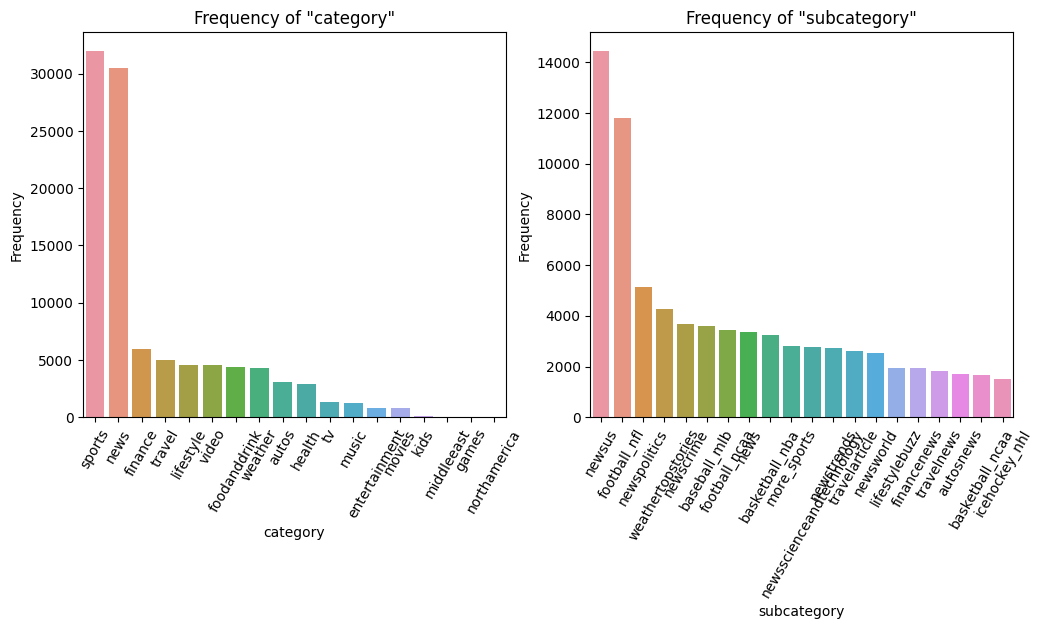

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

for i, col in enumerate(('category', 'subcategory')):
    # Generate the frequency counts (only top 20 max)
    counts = df[col].value_counts().iloc[:20]

    # Create a bar chart
    sns.barplot(x=counts.index, y=counts.values, ax=ax[i])

    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Frequency')
    ax[i].set_title(f'Frequency of "{col}"')
    ax[i].set_xticklabels(counts.index, rotation=60)

Correlation between Clicks, Impressions, and CTR

Text(0.5, 1.0, 'Numeric column correlations')

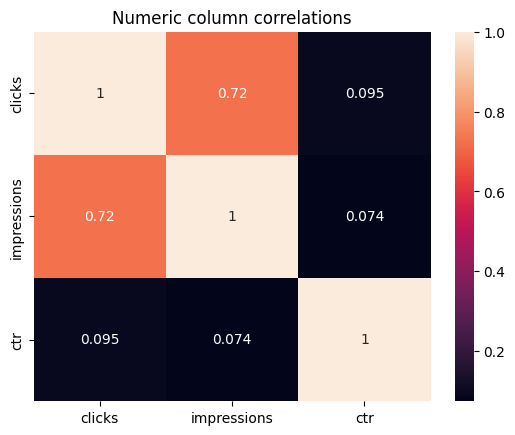

In [9]:
corr = df[['clicks', 'impressions', 'ctr']].corr()
sns.heatmap(corr, annot=True)
plt.title('Numeric column correlations')

Impressions and clicks highly correlated - no surprise there...

Interestingly high clicks doesn't seem to translate to high CTR.

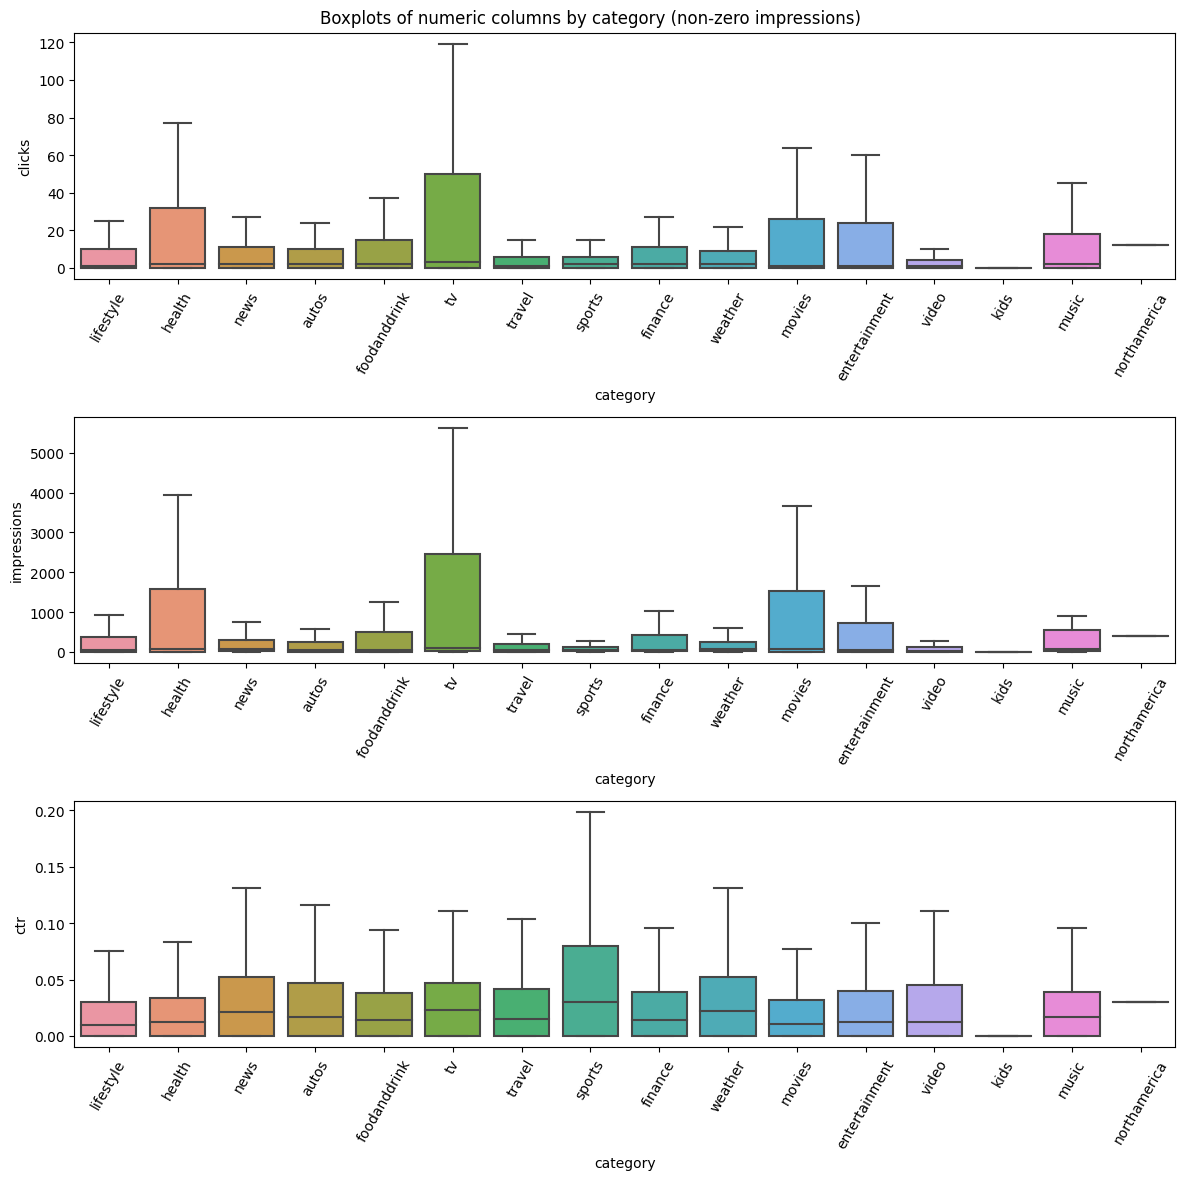

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

for i, col in enumerate(('clicks', 'impressions', 'ctr')):
    sns.boxplot(
        x='category', 
        y=col, 
        data=df[df['impressions']!=0],
        showfliers=False,
        ax=ax[i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=60)

fig.suptitle('Boxplots of numeric columns by category (non-zero impressions)')
fig.tight_layout()

In [11]:
cat_by_ctr = df[df['impressions']!=0]\
    .groupby('category')[['clicks', 'impressions', 'ctr']]\
    .mean()\
    .sort_values(by='ctr', ascending=False)\
    .reset_index()
pd.concat(
    (cat_by_ctr.head(), cat_by_ctr.tail())
)

,category,clicks,impressions,ctr
0,sports,51.951907,1105.925305,0.056983
1,news,136.116498,3111.050806,0.039660
2,weather,57.698063,1125.992077,0.038975
3,autos,119.668177,4354.468856,0.038620
4,video,46.491071,1008.906994,0.037621
11,entertainment,424.582173,13975.977716,0.029758
12,health,158.304088,4350.970090,0.027735
13,movies,195.298701,6065.103896,0.027116
14,lifestyle,225.136631,5507.220848,0.026346
15,kids,0.787234,27.638298,0.013016


Entertainment categories (tv, movies, entertainment) and health have the highest impressions and clicks. 

However, this does not correlate exactly with click-through rates, where articles about sport, news, and weather see the highest engagement.

In [12]:
subcat_by_ctr = df[df['impressions']!=0]\
    .groupby('subcategory')[['clicks', 'impressions', 'ctr']]\
    .mean()\
    .sort_values(by='ctr', ascending=False)\
    .reset_index()
pd.concat(
    (subcat_by_ctr.head(), subcat_by_ctr.tail())
)

,subcategory,clicks,impressions,ctr
0,sports_news,18240.000000,167121.000000,0.109142
1,topnews,9349.000000,88123.000000,0.106090
2,newsscience,29.666667,512.333333,0.094971
3,basketball_nba_videos,5.500000,685.000000,0.087896
4,mma,14.283105,291.146119,0.084397
220,autosreview,0.000000,4.333333,0.000000
221,autospassenger,0.000000,3.000000,0.000000
222,autoslosangeles,0.000000,26.000000,0.000000
223,autoscompact,0.000000,6.000000,0.000000
224,cookingschool,0.000000,23.000000,0.000000


At the subcategory level, the highest click-through rates are for news related to sports, top stories, and science.

High variability between categories indicate that category and subcategory are likely good predictors of CTR.

Impact of title length on impressions, clicks, and CTR

Text(0.5, 1.0, 'CTR by title length')

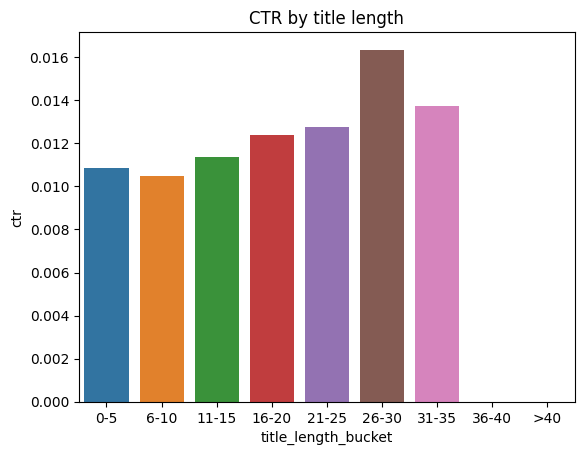

In [13]:
df['title_length'] = df['title'].str.split(' ').apply(len)
df['title_length_bucket'] = pd.cut(
    df['title_length'], 
    bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, float('inf')],
    labels=['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', 
            '36-40', '>40']
)

avg_ctr_title_len = df.groupby('title_length_bucket')['ctr']\
    .mean().reset_index()

sns.barplot(x='title_length_bucket', y='ctr', data=avg_ctr_title_len)
plt.title('CTR by title length')

There is a noticable relationship between title length and CTR, where the optimal length appears to be ~6-10 words.

# 4. Baseline Model

The main aim of this project will be to see if we can predict click-through rate and subcategory using the article title contents.

As such, let's put together a simple baseline model for each use-case.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, r2_score, mean_absolute_error)
from transformers import AutoModel, AutoTokenizer
from scipy.stats import mode
import torch
from tqdm import tqdm

# Load the pre-trained transformer model
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = model.to(device)

# Tokenize the sentences
tokenized = df['title'].apply(
    lambda x: tokenizer.encode(
        x, add_special_tokens=True, max_length=64, truncation=True))

# Process sentences in batches
batch_size = 100
embeddings = []
for i in tqdm(range(0, len(tokenized), batch_size)):
    batch_tokenized = tokenized[i:i+batch_size]
    max_len = max([len(t) for t in batch_tokenized])
    padded = np.array([t + [0]*(max_len-len(t)) for t in batch_tokenized])
    input_ids = torch.tensor(padded).to(device)
    with torch.no_grad():
        batch_embeddings = model(input_ids)[0].cpu().numpy()
        embeddings.append(batch_embeddings)

# Pool the word embeddings to sentence embeddings
embeddings = [e.mean(axis=1) for e in embeddings]

# Concatenate embeddings from batches
embeddings = np.concatenate(embeddings, axis=0)


c:\Users\aghou\.conda\envs\NTTTrainModels\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%

In [15]:
# Encode the target
encoder = LabelEncoder()
y = encoder.fit_transform(df['subcategory'])

In [16]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2)

Baseline dummy classifier - always predicts mode class

In [17]:
# Dummy model for 'subcategory'
# Predict the mode of y_train for all targets in y_test
y_pred = np.full(y_test.shape, mode(y_train, None).mode)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {accuracy:.2f}')
print(f'F1 (micro): {f1_micro:.2f}')
print(f'F1 (macro): {f1_macro:.2f}')

Accuracy: 0.14
F1 (micro): 0.14
F1 (macro): 0.00


C:\Users\aghou\AppData\Local\Temp\ipykernel_3264\1116663055.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  y_pred = np.full(y_test.shape, mode(y_train, None).mode)


Random forest classifier - simple, non-optimized ML model

In [18]:
# Train a RF model to predict the 'subcategory'
k = 5  # number of neighbors
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

# Predict the 'subcategory' on the validation set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {accuracy:.2f}')
print(f'F1 (micro): {f1_micro:.2f}')
print(f'F1 (macro): {f1_macro:.2f}')

Accuracy: 0.41
F1 (micro): 0.41
F1 (macro): 0.07


Not a mindblowing result, but significant gains over the baseline. 

A good starting point to compare with deep learning models.

Now to fit the CTR model...

In [19]:
y_with_imp = df[['ctr', 'impressions']].to_numpy()

emb_new = []
y_new = []
for e, tar in zip(embeddings, y_with_imp):
    # We're not interested in cases with no impressions (poor information)
    if tar[1] == 0:
        continue
    emb_new.append(e)
    y_new.append(np.array(tar[0]))
    
# Concatenate data
embeddings = np.stack(emb_new)
y = np.stack(y_new)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2)


Baseline dummy regressor - always predicts mean value

In [20]:
# Dummy model for 'subcategory'
# Predict the mode of y_train for all targets in y_test
y_pred = np.full(y_test.shape, np.mean(y_train))

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'R^2: {r2:.2f}')
print(f'MAE: {mae:.3f}')

R^2: -0.00
MAE: 0.042


Random forest regressor - unoptimized

In [21]:
# Train a RF model to predict the 'subcategory'
k = 5  # number of neighbors
reg = RandomForestRegressor(n_jobs=-1)
reg.fit(X_train, y_train)

# Predict the 'ctr' on the validation set
y_pred = reg.predict(X_test)

# Evaluate the model
r2 = reg.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'R^2: {r2:.2f}')
print(f'MAE: {mae:.3f}')

R^2: -0.06
MAE: 0.043


Simple model unable to improve on dummy